In [1]:
using AutoGrad

type State
    pos    :: Float64
    price  :: Float64
    profit :: Float64
    x      :: Vector{Float64}
end

linear_fit(y) = (x=1:length(y);hcat(ones(x), x) \ y)

function loss(wb, x)
    (w,b) = wb
    y = tanh(w*x + b)
    sum(y)
end
gradfun = grad(loss)

Pθ = 0.9 # threshold of probability
lr = 0.01 # learning rate
To  = 1000 # open back time
Tc  = 200  # close back time

srand(100)
w=Any[5*randn(1,To)/√To, 0.0]; # initialize parameters

2-element Array{Any,1}:
  [-0.10406 0.0606767 … -0.204307 0.146921]
 0.0                                       

In [2]:
IF_files = String[]
for (root, dirs, files) in walkdir("/home/hdd1/YaoLu/train/")
    for file in files
        file[1:2] == "IF" && push!(IF_files,joinpath(root, file))
    end
end

In [3]:
function train(w,file)
    write("temp.txt",String(read(file)[253:end]))
    data = readcsv("temp.txt");
    data[data.==""] = 0.0
    new::Array{Float64,1} = Float64.(data[10:end-10,3])
    buy::Array{Float64,1} = Float64.(data[10:end-10,18])
    sell::Array{Float64,1} = Float64.(data[10:end-10,20]);
    profit = 0.0

    s = State(0,0,0,Vector{Float64}()) 
    profit = 0.0
    tbuy = Int[]
    tsell = Int[]
    for t=2000:25000
        if s.pos == 0
            s.x = new[t-To+1:t] - new[t-To:t-1]
            y::Float64 = loss(w, s.x)
            if   abs(y) > Pθ
                s.pos = sign(y)
                s.price = s.pos>0 ? sell[t] : buy[t]
                s.pos>0 ? push!(tbuy,t) : push!(tsell,t)
            end
        else
            slope::Float64 = linear_fit(new[t-Tc+1:t] - new[t])[1]
            if (new[t]-s.price)*s.pos < 0 || slope*s.pos < 0.0
                adv_price = s.pos>0 ? buy[t] : sell[t] # adversary price
                s.profit = s.pos*(adv_price-s.price) - 0.6
                profit += s.profit 
                s.pos>0 ? push!(tsell,t) : push!(tbuy,t)

                g = gradfun(w, s.x)
                for i in 1:length(w)
                    w[i] += lr*s.profit*s.pos*g[i]
                end
                s.pos = 0.0
                s.price = 0.0
            end
        end
    end
    profit
end

train (generic function with 1 method)

In [ ]:
for file in IF_files[1:40]
    for i = 1:30
        train(w,file)
    end
end
train(w,IF_files[41])

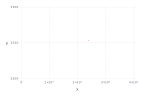

In [13]:
using Gadfly
plot(layer(y=new,Geom.line,Theme(line_width=0.03mm)),
layer(x=tbuy,y=new[tbuy],Geom.point,Theme(default_color=colorant"red",default_point_size=0.3mm)),
layer(x=tsell,y=new[tsell],Geom.point,Theme(default_color=colorant"green",default_point_size=0.3mm)))